## *Load Libraries*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
warnings.filterwarnings('ignore')

### *Load Data*

In [4]:
df = pd.read_parquet('vehicles.parquet')

## *Feature Enginiering*

In [5]:
df[['year','odometer','price']].agg({'min','max'})

,year,odometer,price
max,2022.0,10000000.0,3736928711
min,1900.0,0.0,0


In [6]:
lower_limit,upper_limit = 1000,100_000
df = df.query('price>@lower_limit and price<@upper_limit')

In [7]:
lower_limit,upper_limit = 3000,300_000
df = df.query('odometer>@lower_limit and odometer<@upper_limit')

We define the lower and upper intervals, to extract the data in a more normal range.

In [8]:
df = df.query('year>=2000')

We select the cars belonging to the 2000 model, since they are the most used today.

In [9]:
df[['year','odometer','price']].agg({'min','max'})

,year,odometer,price
max,2022.0,299999.0,99999
min,2000.0,3002.0,1003


We verify the changes.

In [10]:
plt.style.use('ggplot')

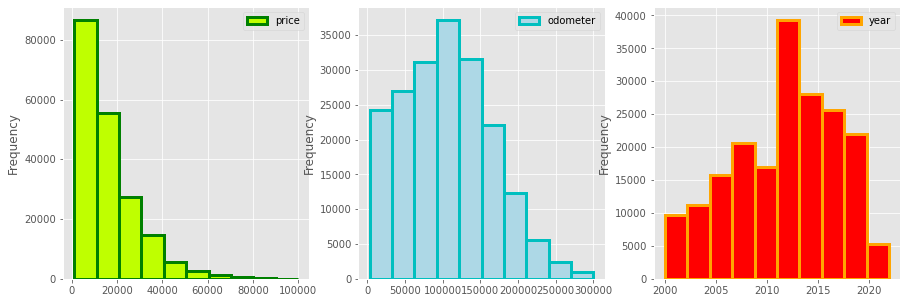

In [11]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
df.plot(kind = "hist",y = 'price',ax = ax[0],color = "#bfff00",ec = "green",lw = 3)
df.plot(kind = "hist",y = 'odometer',ax = ax[1],color = "lightblue",ec = "c",lw = 3)
df.plot(kind = "hist",y = 'year',ax = ax[2],color = "red",ec = "orange",lw = 3)
plt.show()

A better distribution of the data is observed comparing them with the previous one.

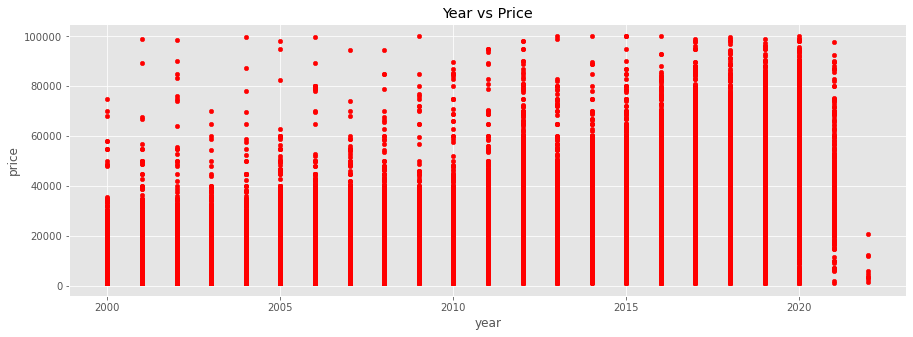

In [12]:
df.plot(kind = "scatter",
        x = "year",
        y = "price",
        c = "r",
       figsize = (15,5),
       title = "Year vs Price") 

plt.show()

There are vehicles with an older build date and they are priced quite high for the model year, even rivaling the price of vehicles with a more recent year.

In [13]:
df = df.query('year<2022')

The cars belonging to the year 2022 have a too low price, since supposedly these latest models must have a higher price, in addition to the pre-owned market, people seek to get a better car based on the price of a new car with lower benefits.

## *Replace Outlires*

In [14]:
df_2000_2010 = df.query('year<=2010')
df_2011_2021 = df.query('year>=2011')

We create two subsets to clean the data better.

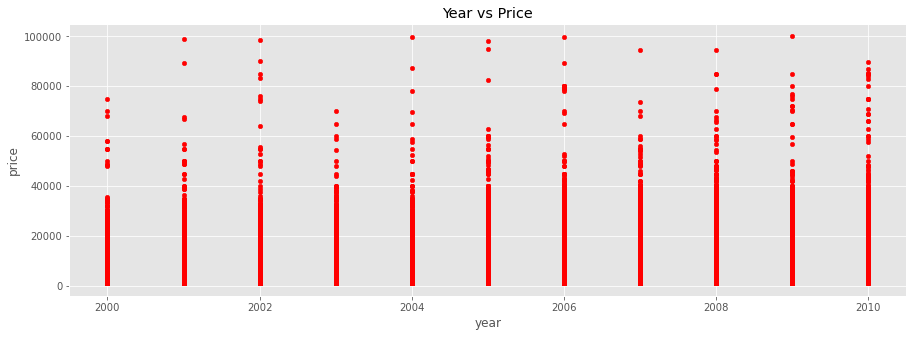

In [15]:
df_2000_2010.plot(kind = "scatter",
        x = "year",
        y = "price",
        c = "r",
       figsize = (15,5),
       title = "Year vs Price") 

plt.show()

In [31]:
def delete_outlires_year(df,upper_limits):
    year_dict = {}
    years = np.sort(df.year.unique())
    
    for year,upper_limit in zip(years,upper_limits):
        df_year = df.query('year==@year')
        df_year['price'] = np.where(df_year['price']>upper_limit,np.nan,df_year['price'])

        year_dict[year] = df_year
        
    return year_dict

We will take the values that are out of the normal range as lost values to later replace them with values that are in a normal range.

In [32]:
upper_limits = df_2000_2010.groupby('year')['price'].quantile(0.90)

For cars from 2010 model year and up, we use the average value to set the upper range.

In [33]:
dict_2000_2010 = delete_outlires_year(df_2000_2010,upper_limits)

In [34]:
def replace_outlires(dict_year):
    
    dict_year_clear = dict_year.dropna(subset = ['price'])
    dict_year_null = dict_year[dict_year.price.isnull()]
    
    size = dict_year_null.shape[0]
    
    q95 = np.round(dict_year_clear.price.quantile(0.95),2)
    q99 = np.round(dict_year_clear.price.quantile(0.99),2)
    
    
    dict_year_null['price'] = np.random.randint(q95,q99,size)
    
    dict_year_clear = pd.concat([dict_year_clear,dict_year_null])
    
    return dict_year_clear

We replace the missing values with values from a random sample.

In [35]:
for year in np.arange(2000,2011,1):

    dict_2000_2010[year] = replace_outlires(dict_2000_2010[year])

We replace the null values belonging to the price variable.

In [36]:
upper_limits = df_2011_2021.groupby('year')['price'].quantile(0.99)

In [37]:
upper_limits

year
2011.0    39000.00
2012.0    49912.00
2013.0    43500.00
2014.0    48614.50
2015.0    56995.00
2016.0    60000.00
2017.0    69999.00
2018.0    69999.00
2019.0    79996.32
2020.0    86999.00
2021.0    89950.35
Name: price, dtype: float64

Because these are more recent cars, we can apply the quantile method where we ask for the value belonging to 99% of the data for the price variable.

In [38]:
dict_2011_2021 = delete_outlires_year(df_2011_2021,upper_limits)

In [39]:
for year in np.arange(2011,2022,1):

    dict_2011_2021[year] = replace_outlires(dict_2011_2021[year])

Again we replace the missing values.

In [40]:
def concatene_year_200_2010():
    
    year_2000 = dict_2000_2010[2000]
    year_2001 = dict_2000_2010[2001]
    year_2002 = dict_2000_2010[2002]
    year_2003 = dict_2000_2010[2003]
    year_2004 = dict_2000_2010[2004]
    year_2005 = dict_2000_2010[2005]

    year_2006 = dict_2000_2010[2006]
    year_2007 = dict_2000_2010[2007]
    year_2008 = dict_2000_2010[2008]
    year_2009 = dict_2000_2010[2009]
    year_2010 = dict_2000_2010[2010]
    
    df_year_2000_2010 = pd.concat([year_2000,
                                   year_2001,
                                   year_2002,
                                   year_2003,
                                   year_2004,
                                   year_2005,
                                  year_2006,
                                  year_2007,
                                  year_2008,
                                  year_2009,
                                  year_2010])
    
    
    return df_year_2000_2010

In [41]:
df_year_2000_2010 = concatene_year_200_2010()

In [42]:
def concatene_year_2011_2021():
    
    year_2011 = dict_2011_2021[2011]
    year_2012 = dict_2011_2021[2012]
    year_2013 = dict_2011_2021[2013]
    year_2014 = dict_2011_2021[2014]
    year_2015 = dict_2011_2021[2015]
    
    year_2016 = dict_2011_2021[2016]
    year_2017 = dict_2011_2021[2017]
    year_2018 = dict_2011_2021[2018]
    year_2019 = dict_2011_2021[2019]
    year_2020 = dict_2011_2021[2020]
    
    year_2021 = dict_2011_2021[2021]
    
    
    df_year_2011_2021 = pd.concat([year_2011,
                                  year_2012,
                                  year_2013,
                                  year_2014,
                                  year_2015,
                                 year_2016,
                                 year_2017,
                                 year_2018,
                                 year_2019,
                                 year_2020,
                                 year_2021])
    
    return df_year_2011_2021

In [43]:
df_year_2011_2021 = concatene_year_2011_2021()

In [44]:
df2 = pd.concat([df_year_2000_2010,df_year_2011_2021])

We concatenate the data, already preprocessed.

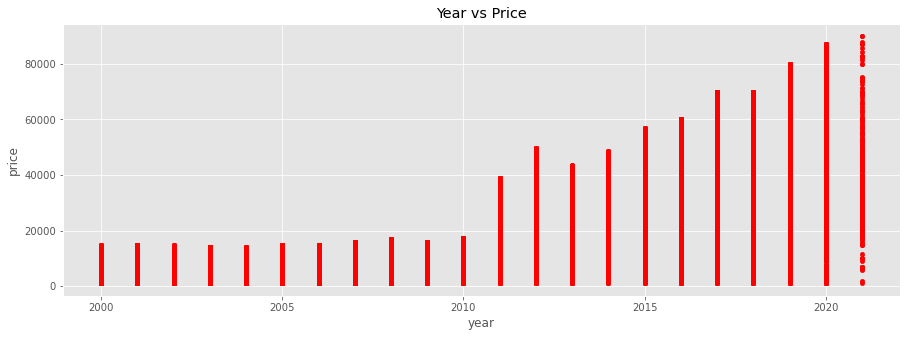

In [45]:
df2.plot(kind = "scatter",
        x = "year",
        y = "price",
        c = "r",
       figsize = (15,5),
       title = "Year vs Price") 

plt.show()

Thanks to the treatment of atypical values, a better behavior is seen, since it follows the trend that the more recent year of manufacture will be, the more the cost of the car will be.

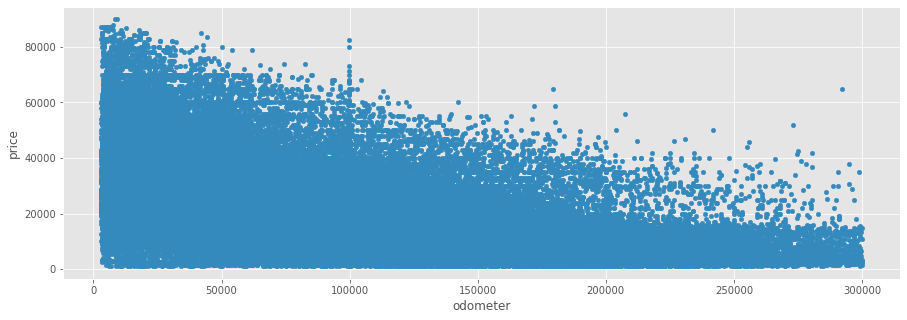

In [46]:
df2.plot(kind = "scatter",
         x = "odometer",
         y = "price",
        figsize = (15,5))
plt.show()

In [47]:
df2.query('odometer>280_000').price.max()

65000.0

There is a high mileage car priced quite high for its degree of wear, I will choose to remove it.

In [48]:
df2 = df2.query('price!=65000')

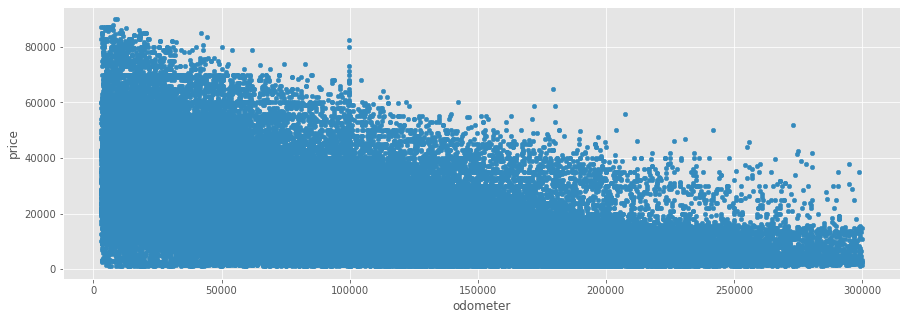

In [49]:
df2.plot(kind = "scatter",
         x = "odometer",
         y = "price",
        figsize = (15,5))
plt.show()

In [50]:
df2.groupby('condition')['price'].quantile(0.99).sort_values()

condition
fair         15291.00
salvage      22397.00
good         48675.38
excellent    53500.00
like new     63386.62
new          76047.00
Name: price, dtype: float64

The price is very high, for the state of the vehicle, for which I will choose to eliminate them, to avoid overfitting in the development of the predictive model.

In [51]:
fair = df2.query('condition=="fair" and price<6000')
df2 = df2.query('condition!="fair"')

In [65]:
df3 = pd.concat([fair,df2])

## *Model Names*

In [66]:
model_names = [model[:6] for model in df3.model]
df3.model = model_names

We clean the name of the cars, since there are misspelled vehicle names and therefore it can be simplified.

## *Remove Outlires Pirce*

In [67]:
df3.query('year>=2015 and price<5500') \
.sample(5,random_state = 42)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
379015,4000.0,2015.0,dodge,durang,like new,6.0,gas,66164.0,clean,automatic,rwd,other,white
306685,2000.0,2019.0,chevrolet,trax l,like new,4.0,gas,37000.0,clean,automatic,fwd,SUV,white
108830,5000.0,2015.0,ford,fiesta,excellent,4.0,gas,130000.0,clean,automatic,fwd,sedan,silver
92735,2995.0,2015.0,chevrolet,malibu,None,NaN,gas,100000.0,clean,automatic,None,None,None
111312,2500.0,2015.0,bmw,x5 xdr,like new,6.0,gas,80653.0,clean,automatic,4wd,SUV,white


There is no way that there are more recent model years with prices quite low, it is strange that a 2020 Nissan Altima model with low mileage is so ridiculously priced.

In [68]:
condition = (df3.year>=2015) & (df3.price<5500)

In [57]:
df3['condition_data'] = np.where(condition,'outlier','normal')

In [58]:
df3 = df3.query('condition_data=="normal"')

In [59]:
df3 = df3[df3.condition_data=="normal"]
df3 = df3.drop(columns = ['condition_data'])

In [60]:
df3.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
3801,2750.0,2000.0,ford,lexuse,fair,6.0,gas,276000.0,clean,automatic,rwd,SUV,yellow
5010,2000.0,2000.0,chevrolet,s10 pi,fair,6.0,gas,136500.0,clean,automatic,4wd,pickup,blue
5176,4300.0,2000.0,ford,explor,fair,6.0,gas,145000.0,clean,manual,4wd,SUV,red
6650,1500.0,2000.0,mitsubishi,monter,fair,6.0,gas,148000.0,clean,automatic,4wd,SUV,purple
8145,1250.0,2000.0,subaru,outbac,fair,NaN,gas,250000.0,clean,automatic,None,None,blue


In [62]:
drops = ['condition','drive','paint_color']
df3 = df3.drop(columns = drops)

In [64]:
df3

In [62]:
url = "C:\\Users\\PC\\Desktop\\Ciencias de datos\\Proyectos\\Criaglist\\data\\vehiclesv2.parquet"
df3.to_parquet(url)

In [65]:
df3.corr()

,price,year,cylinders,odometer
price,1.000000,0.695095,0.233967,-0.576542
year,0.695095,1.000000,-0.179995,-0.657997
cylinders,0.233967,-0.179995,1.000000,0.146167
odometer,-0.576542,-0.657997,0.146167,1.000000


Histograms offer a better distribution of data.